In [50]:
import importlib
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from customer_segmentation.utils import functions

importlib.reload(functions)

# Set pandas to display all columns
pd.set_option("display.max_columns", None)

In [9]:
# import data
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, os.path.pardir, "data")
file_name = "cohort_data.csv"
file_path = os.path.join(data_dir, file_name)

cohort = pd.read_csv(file_path)

### **Preprocessing**

In [10]:
# convert data types
cohort["user_id"] = cohort["user_id"].astype(str)
cohort["cnt_trips"] = cohort["cnt_trips"].astype(int)
cohort["min_signup_date"] = pd.to_datetime(cohort["min_signup_date"])

**Explore distribution**

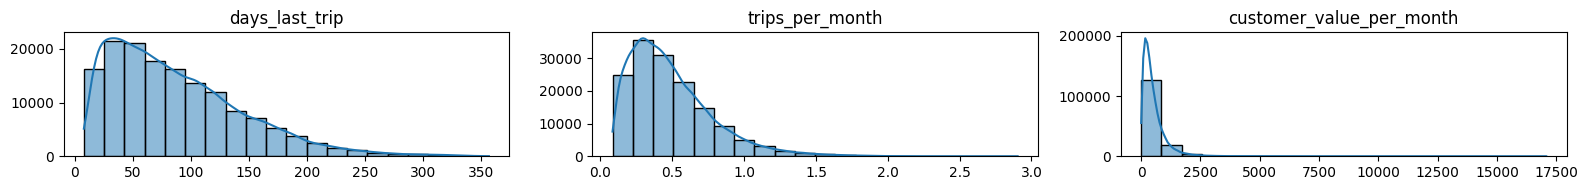

In [16]:
metrics = ["days_last_trip", "trips_per_month", "customer_value_per_month"]

functions.plot_univariate_series(
    df=cohort, metrics=metrics, n_cols=3, plot_type=sns.histplot
)

**Scaling metrics**
- For quantile-based scores, metrics will be log-transformed  
- For clustering analysis the metrics will also be scaled

In [18]:
features_log = {
    "recency_log": "days_last_trip",
    "frequency_log": "trips_per_month",
    "monetary_log": "customer_value_per_month",
}
X_log = np.log1p(cohort[list(features_log.values())])
cohort[list(features_log.keys())] = X_log

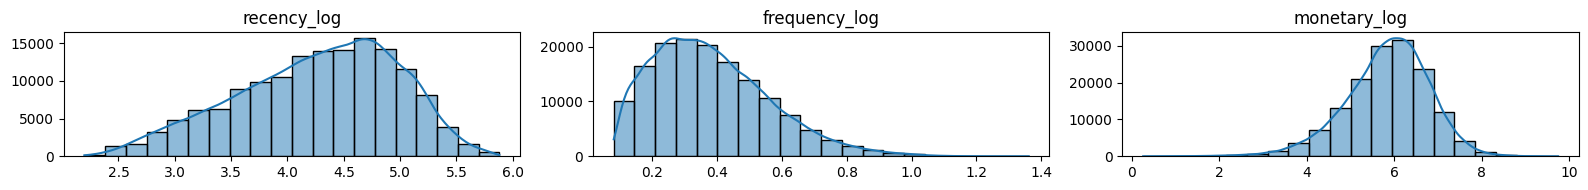

In [19]:
functions.plot_univariate_series(
    df=cohort, metrics=list(features_log.keys()), n_cols=3, plot_type=sns.histplot
)

In [20]:
features_scaled = {
    "recency_scaled": "days_last_trip",
    "frequency_scaled": "trips_per_month",
    "monetary_scaled": "customer_value_per_month",
}
scaler = StandardScaler()
X_log = np.log1p(cohort[list(features_scaled.values())])
X_scaled = scaler.fit_transform(X_log)
cohort[list(features_scaled.keys())] = X_scaled

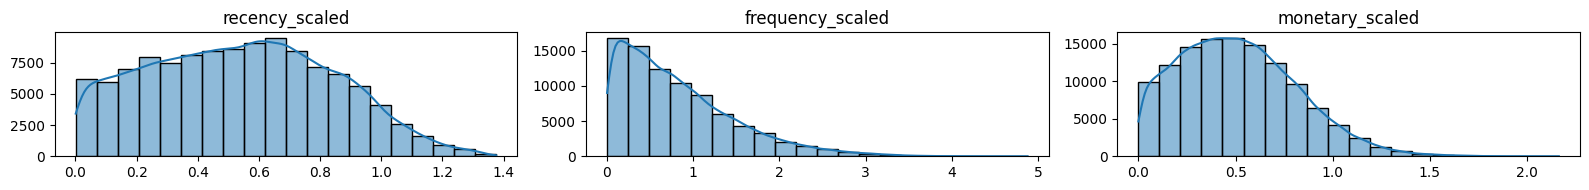

In [21]:
functions.plot_univariate_series(
    df=cohort, metrics=list(features_scaled.keys()), n_cols=3, plot_type=sns.histplot
)

### **RFM analysis**

**RFM scores based on quantiles**

In [ ]:
# Recency: days_last_trip
# Frequency: trips_per_month
# Monetary: customer_value_per_month
# Tenure: time since first transaction (optional)

cohort["R_score"] = pd.qcut(cohort["recency_log"], q=5, labels=[5, 4, 3, 2, 1])
cohort["F_score"] = pd.qcut(cohort["frequency_log"], q=5, labels=[1, 2, 3, 4, 5])
cohort["M_score"] = pd.qcut(cohort["monetary_log"], q=5, labels=[1, 2, 3, 4, 5])

cohort["RFM_score"] = cohort[["R_score", "F_score", "M_score"]].astype(int).sum(axis=1)

In [28]:
conditions = [
    (cohort["RFM_score"] >= 13),
    (cohort["RFM_score"] >= 10) & (cohort["RFM_score"] < 13),
    (cohort["RFM_score"] >= 7) & (cohort["RFM_score"] < 10),
    (cohort["RFM_score"] >= 4) & (cohort["RFM_score"] < 7),
    (cohort["RFM_score"] < 4),
]

labels = [
    "Champions",
    "Loyal Customers",
    "Potential Loyalists",
    "At risk",
    "Lost",
]

cohort["RFM_groups"] = np.select(conditions, labels, default="Unknown")
cohort["RFM_groups"] = cohort["RFM_groups"].astype("category")
cohort["RFM_groups"] = cohort["RFM_groups"].cat.reorder_categories(labels, ordered=True)

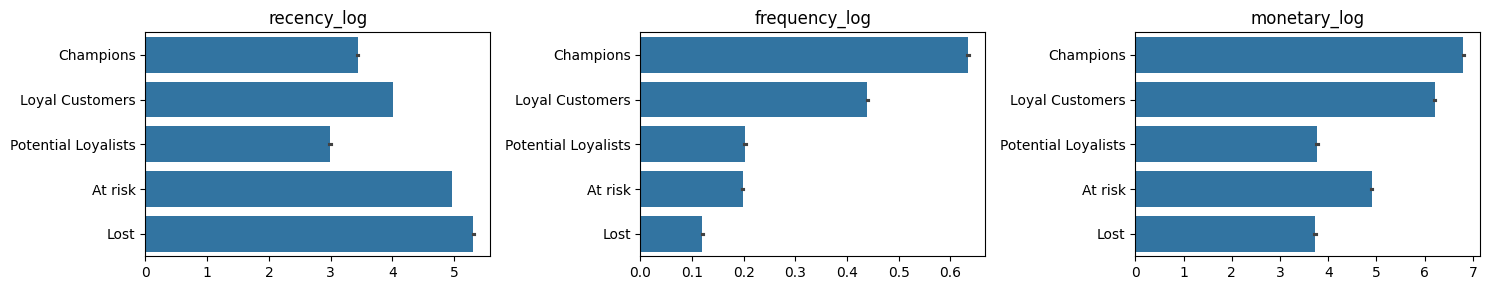

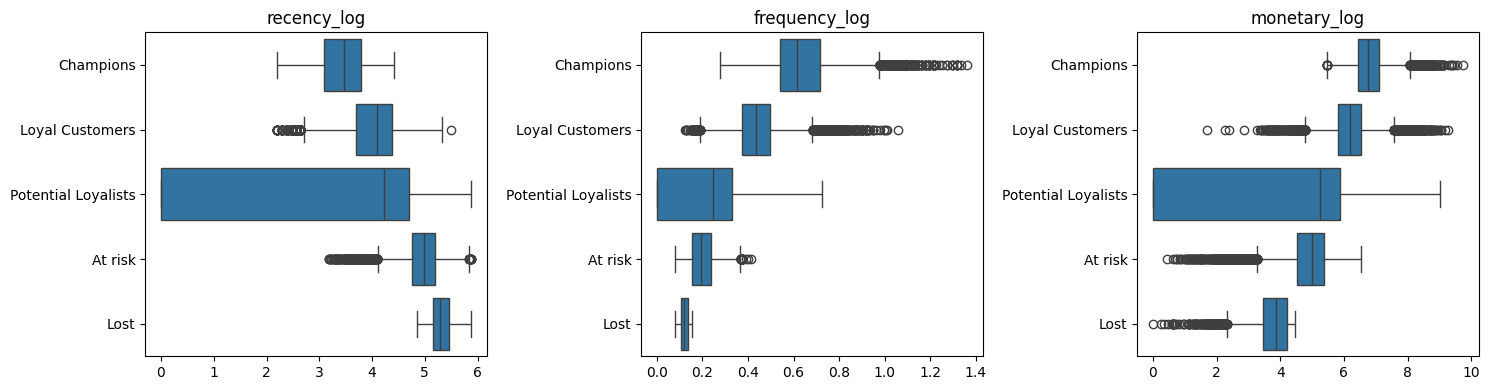

In [65]:
functions.plot_bivariate_series(
    df=cohort,
    category="RFM_groups",
    metrics=list(features_log.keys()),
    n_cols=3,
    plot_type=sns.barplot,
    swap_axes=True,
    fig_width=15,
    fig_height=3,
)
functions.plot_bivariate_series(
    df=cohort,
    category="RFM_groups",
    metrics=list(features_log.keys()),
    n_cols=3,
    plot_type=sns.boxplot,
    swap_axes=True,
    fig_width=15,
    fig_height=4,
)

In [83]:
cohort.groupby("RFM_groups", observed=True)[metrics].mean().round(
    1
).T.style.background_gradient(cmap="YlGnBu", axis=1).format("{:.1f}")

RFM_groups,Champions,Loyal Customers,Potential Loyalists,At risk,Lost
days_last_trip,33.5,60.8,66.2,150.1,206.1
trips_per_month,0.9,0.6,0.2,0.2,0.1
customer_value_per_month,1040.4,596.2,243.0,164.8,47.4


**RFM clustering**

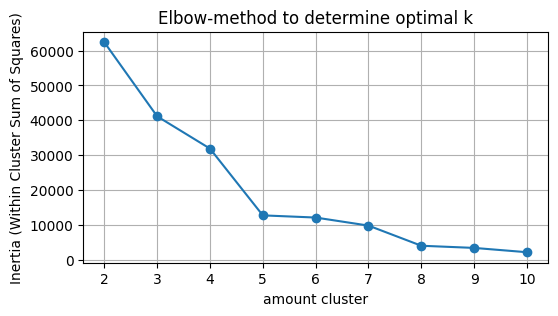

In [ ]:
# estimate k cluster based on interia

X = cohort[list(features_scaled.keys())].astype(int)
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=3, n_init="auto")
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(6, 3))
plt.plot(k_range, inertia, "o-")
plt.xlabel("amount cluster")
plt.ylabel("Inertia (Within Cluster Sum of Squares)")
plt.title("Elbow-method to determine optimal k")
plt.grid(True)
plt.show()

In [98]:
# Perform K-means clustering with best K
kmeans = KMeans(n_clusters=5, n_init=10, random_state=3)
cohort["RFM_cluster"] = kmeans.fit_predict(X)

In [99]:
cohort.groupby("RFM_cluster")[metrics].mean().round(2).T.style.background_gradient(
    cmap="YlGnBu", axis=0
).format("{:.2f}").set_properties(**{"font-size": "12px", "padding": "10px"})

RFM_cluster,0,1,2,3,4
days_last_trip,89.85,0.00,25.71,235.93,42.01
trips_per_month,0.40,0.00,1.36,0.17,0.87
customer_value_per_month,439.67,0.00,1186.60,233.34,845.93


In [101]:
labels = [
    "Champions",
    "Loyal Customers",
    "Potential Loyalists",
    "At-risk Customers",
    "Lost",
]
conditions = [
    (cohort["RFM_cluster"] == 2),
    (cohort["RFM_cluster"] == 4),
    (cohort["RFM_cluster"] == 0),
    (cohort["RFM_cluster"] == 3),
    (cohort["RFM_cluster"] == 1),
]

cohort["RFM_cluster_groups"] = np.select(conditions, labels, default="Unknown")
cohort["RFM_cluster_groups"] = cohort["RFM_cluster_groups"].astype("category")
cohort["RFM_cluster_groups"] = cohort["RFM_cluster_groups"].cat.reorder_categories(
    labels, ordered=True
)

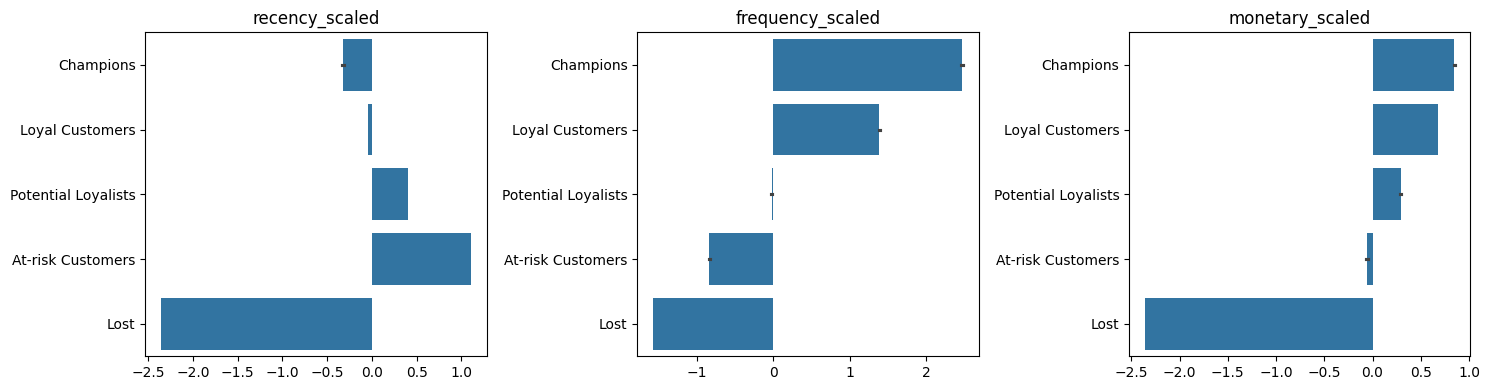

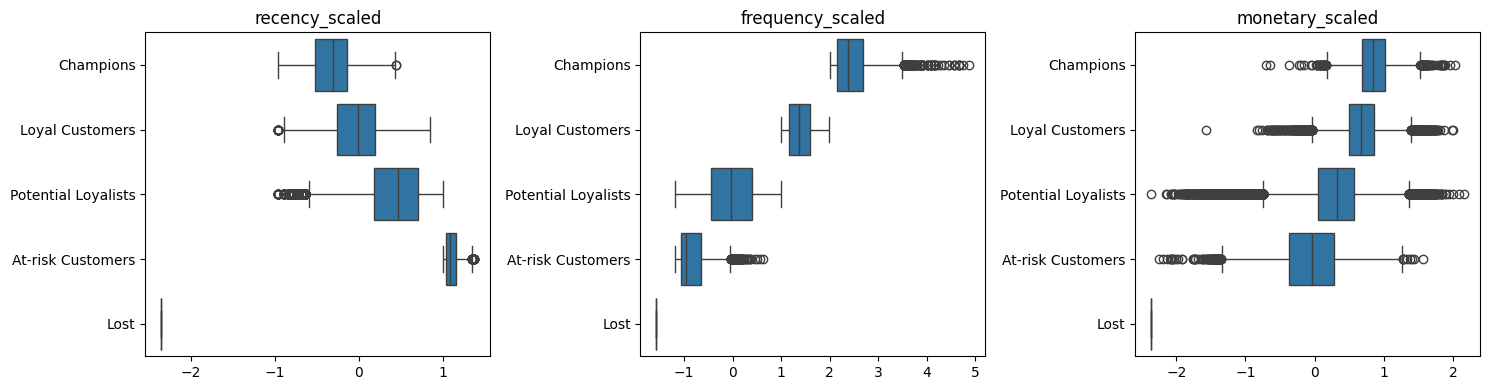

In [103]:
functions.plot_bivariate_series(
    df=cohort,
    category="RFM_cluster_groups",
    metrics=list(features_scaled.keys()),
    n_cols=3,
    plot_type=sns.barplot,
    swap_axes=True,
    fig_width=15,
    fig_height=4,
)
functions.plot_bivariate_series(
    df=cohort,
    category="RFM_cluster_groups",
    metrics=list(features_scaled.keys()),
    n_cols=3,
    plot_type=sns.boxplot,
    swap_axes=True,
    fig_width=15,
    fig_height=4,
)

In [104]:
cohort.groupby("RFM_cluster_groups", observed=True)[metrics].mean().round(
    1
).T.style.background_gradient(cmap="YlGnBu", axis=1).format("{:.1f}")

RFM_cluster_groups,Champions,Loyal Customers,Potential Loyalists,At-risk Customers,Lost
days_last_trip,25.7,42.0,89.9,235.9,0.0
trips_per_month,1.4,0.9,0.4,0.2,0.0
customer_value_per_month,1186.6,845.9,439.7,233.3,0.0


### **Conclusion**
K-Means clustering identified a group of users who made no bookings at all, which were not captured by the quantile-based RFM approach.  
Unlike the fixed quantile method, clustering enables a more nuanced and flexible segmentation of users based on their RFM behavior.

**Export RFM results**

In [118]:
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, os.path.pardir, "data")
data_path = os.path.join(data_dir, "RFM_analysis_results.csv")
cohort.to_csv(data_path, index=False)